## Imports

In [34]:
# Importing machine learning algorithms
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# Importing other packages
import timeit
import pandas as pd
import numpy as np
import neptune
import tempfile
from scipy import stats
import time


import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
import my_functions as mf

import mlflow
import mlflow.catboost
import os


# Importing packages for machine learning operations
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score


import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = "browser"

## Start Experiment

In [35]:
# mlflow.set_tracking_uri("https://dagshub.com/gfragi/PriceIndex.mlflow")


# Set the experiment name in MLflow
instance_Family = 'Memory_optimized'
# General_purpose
# Memory_optimized
# Storage_optimized
# Compute_optimized
# GPU_instance

outlier = 'zscore'

# zscore
# iqr
# lof
# isolation


mlflow.set_experiment(instance_Family)

<Experiment: artifact_location='file:///home/gfragi/Phd_projects/amazonForecast/mlruns/933858221367283980', creation_time=1687250674267, experiment_id='933858221367283980', last_update_time=1687250674267, lifecycle_stage='active', name='Memory_optimized', tags={}>

### Add some experiment tags

In [36]:

# Set tags for the run
tags = {
    "experiment": "catboost_regression",
    "model_type": "CatBoostRegressor",
    # "task_type": "CPU",
    "dataset": "Amazon",
    "year to predict": "2022",
    "all years for prediction": "no",
    "outlier": outlier
}

# Set the tags for the current run
mlflow.set_tags(tags)

In [37]:
# mlflow.end_run()

## Import data 

In [38]:

data_all = pd.read_csv(
    f'./data/instFamily_subsets/{instance_Family}_subset.csv', parse_dates=['EffectiveDate'])

# data = data.drop(['OfferTermCode', 'instanceType', 'instanceFamily', 'OfferingClass'], axis=1)

data_all = data_all.drop(['OfferTermCode', 'instanceFamily', 'Location',
                         'year', 'Tenancy', 'OfferingClass', 'instanceType'], axis=1)

In [39]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176008 entries, 0 to 176007
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   PricePerUnit         176008 non-null  float64       
 1   LeaseContractLength  176008 non-null  int64         
 2   PurchaseOption       176008 non-null  object        
 3   vCPU                 176008 non-null  int64         
 4   Memory               176008 non-null  int64         
 5   operatingSystem      176008 non-null  object        
 6   networkPerformance   176008 non-null  float64       
 7   EffectiveDate        176008 non-null  datetime64[ns]
 8   DiskType             176008 non-null  object        
 9   StorageSize          176008 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 13.4+ MB


In [40]:
# Select regions

In [41]:
# # # replace USEast and USWest to US and EU to Europe
# data_all = data_all.replace({'USEast': 'US', 'USWest': 'US', 'EU': 'Europe'})
# data_all = data_all[(data_all['Location'] != "Africa") & (data_all['Location'] != "MiddleEast") & (data_all['Location']
#                                                                                                    != "Canada") & (data_all['Location'] != "SouthAmerica") & (data_all['Location'] != "AWSGovCloud")]

In [42]:
# data_all = data_all.drop(['Location'], axis=1)

In [43]:
# # create several new date time features
data_all['year'] = data_all['EffectiveDate'].dt.year
# data['day_of_year'] = data['EffectiveDate'].dt.dayofyear
# data['weekday'] = data['EffectiveDate'].dt.weekday
# data['week_of_year'] = data['EffectiveDate'].dt.week
# data['day_of_month'] = data['EffectiveDate'].dt.day
# data['quarter'] = data['EffectiveDate'].dt.quarter

# data.drop('EffectiveDate', axis=1, inplace=True)

### Sort 

In [44]:
data_all.sort_values(by='EffectiveDate')
data_all.reset_index(drop=True)

,PricePerUnit,LeaseContractLength,PurchaseOption,vCPU,Memory,operatingSystem,networkPerformance,EffectiveDate,DiskType,StorageSize,year
0,0.0605,3,Partial Upfront,1,8,RHEL_HA,10.0,2021-03-01,NVMe SSD,59,2021
1,0.1403,1,No Upfront,1,8,RHEL_HA,10.0,2021-03-01,NVMe SSD,59,2021
2,0.1466,1,No Upfront,1,8,RHEL_HA,10.0,2021-03-01,NVMe SSD,59,2021
3,0.1231,3,No Upfront,1,8,RHEL_HA,10.0,2021-03-01,NVMe SSD,59,2021
4,0.0721,1,Partial Upfront,1,8,RHEL_HA,10.0,2021-03-01,NVMe SSD,59,2021
...,...,...,...,...,...,...,...,...,...,...,...
176003,4.1430,3,No Upfront,64,976,Linux,1.0,2021-01-01,SSD,1920,2021
176004,3.7550,1,Partial Upfront,64,976,Linux,1.0,2021-01-01,SSD,1920,2021
176005,3.3360,1,Partial Upfront,64,976,Linux,1.0,2021-01-01,SSD,1920,2021
176006,2.1700,3,Partial Upfront,64,976,Linux,1.0,2021-01-01,SSD,1920,2021


# Outlier Methods

## IsolationForest

In [45]:
from sklearn.ensemble import IsolationForest

if outlier == 'isolation':

    # Select the column(s) you want to detect outliers in
    columns_to_check = ['PricePerUnit', 'vCPU', 'Memory']

    # Create an Isolation Forest object
    # Adjust the contamination parameter as needed
    isolation_forest = IsolationForest(contamination=0.1)

    # Fit the Isolation Forest model and predict outlier labels
    outlier_labels = isolation_forest.fit_predict(data_all[columns_to_check])

    # Identify outliers based on the predicted labels
    outliers = data_all[outlier_labels == -1]

    # Exclude outliers from the dataset
    data_all = data_all[outlier_labels != -1]

    # Print the outliers
    print("Outliers:")
    print(outliers)

    # Print the cleaned dataset
    print("Cleaned Data:")
    print(data_all)

## LOF

In [46]:
from sklearn.neighbors import LocalOutlierFactor


if outlier == 'lof':

    # Select the column(s) you want to detect outliers in
    columns_to_check = ['PricePerUnit']

    # Create a LOF object
    # Adjust parameters as needed
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

    # Fit the LOF model and predict outlier scores
    outlier_scores = lof.fit_predict(data_all[columns_to_check])

    # Identify outliers based on the predicted scores
    outliers = data_all[outlier_scores == -1]

    # Exclude outliers from the dataset
    data_all = data_all[outlier_scores != -1]

    # Print the outliers
    print("Outliers:")
    print(outliers)

    # Print the cleaned dataset
    print("Cleaned Data:")
    print(data_all)
else:
    pass

## Interquartile Range (IQR)



In [47]:

if outlier == 'iqr':
    # Select the column(s) you want to detect outliers in
    columns_to_check = ['PricePerUnit']

    # Calculate the IQR for each column
    Q1 = data_all[columns_to_check].quantile(0.25)
    Q3 = data_all[columns_to_check].quantile(0.75)
    IQR = Q3 - Q1

    # Define a threshold for identifying outliers
    threshold = 2

    # Determine the lower and upper bounds for outlier detection
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    # Identify outliers by filtering the dataset
    outliers = data_all[~((data_all[columns_to_check] >= lower_bound) & (
        data_all[columns_to_check] <= upper_bound)).all(axis=1)]

    # Exclude outliers from the dataset
    data_all = data_all[((data_all[columns_to_check] >= lower_bound) & (
        data_all[columns_to_check] <= upper_bound)).all(axis=1)]

    # Print the outliers
    print("Outliers:")
    print(outliers)

    # Print the cleaned dataset
    print("Cleaned Data:")
    print(data_all)
else:
    pass

## Z-score

In [48]:
if outlier == 'zscore':

    # Select the column(s) you want to detect outliers in
    columns_to_check = ['PricePerUnit']

    # Compute the Z-scores for each data point
    z_scores = np.abs(stats.zscore(data_all[columns_to_check]))

    # Define a threshold for identifying outliers
    threshold = 0.75

    # Find the indices of outliers
    outlier_indices = np.where(z_scores > threshold)

    # Get the rows containing outliers
    outliers = data_all.iloc[outlier_indices[0]]

    # Exclude outliers from the dataset
    data_all = data_all.drop(data_all.index[outlier_indices[0]])

    # Print the outliers
    print(outliers)

    mlflow.log_param("z-threshold", threshold)

else:
    pass

        PricePerUnit  LeaseContractLength PurchaseOption  vCPU  Memory  \
9           20.96135                    1     No Upfront    64    2048   
10          23.04293                    1     No Upfront    64    2048   
11          16.01293                    3     No Upfront    64    2048   
15          17.10160                    3     No Upfront    64    2048   
49          13.36740                    1     No Upfront    64    1024   
...              ...                  ...            ...   ...     ...   
175891      13.72173                    3     No Upfront    96    3072   
175895      15.60167                    3     No Upfront    96    3072   
175953      16.72000                    1     No Upfront    64     192   
175954      18.07500                    1     No Upfront    64     192   
175959      13.10000                    3     No Upfront    64     192   

       operatingSystem  networkPerformance EffectiveDate  DiskType  \
9              Windows                50.

##  Create a quarterly seasonality column


In [49]:
# Convert EffectiveDate column to datetime format
data_all['EffectiveDate'] = pd.to_datetime(data_all['EffectiveDate'])

# Extract the quarter component from the EffectiveDate column
data_all['Quarter'] = data_all['EffectiveDate'].dt.quarter

# Create a dictionary mapping quarter numbers to season labels
seasons = {1: 'Q1', 2: 'Q2', 3: 'Q3', 4: 'Q4'}

# Map the quarter numbers to season labels using the dictionary
data_all['Seasonality'] = data_all['Quarter'].map(seasons)

In [50]:
data_all

data_all = data_all.drop(['Seasonality'], axis=1)

# Years

## Select which years will be used for prediction

In [51]:
data_all.year.unique()

array([2021, 2022, 2020, 2019, 2018, 2016, 2017])

In [52]:
data_pred = data_all[data_all['year'] > 2021]
data_pred = data_pred.sort_values(by='EffectiveDate')
data_pred = data_pred.reset_index(drop=True)
data_pred.year.unique()

array([2022])

In [53]:
data = data_all[(data_all['year'] > 2020) & (data_all['year'] < 2022)]
data = data.sort_values(by='EffectiveDate')
data = data.reset_index(drop=True)
data.year.unique()


mlflow.log_param("Years used to predict", data.year.unique())

array([2021])

In [54]:
data.head()

,PricePerUnit,LeaseContractLength,PurchaseOption,vCPU,Memory,operatingSystem,networkPerformance,EffectiveDate,DiskType,StorageSize,year,Quarter
0,4.6010,3,No Upfront,64,976,Linux,1.0,2021-01-01,SSD,1920,2021,1
1,0.4401,3,Partial Upfront,32,26,Linux,10.0,2021-01-01,NVMe SSD,1900,2021,1
2,3.3730,1,No Upfront,16,488,Linux,10.0,2021-01-01,SSD,480,2021,1
3,1.5300,3,No Upfront,16,488,Linux,10.0,2021-01-01,SSD,480,2021,1
4,1.6060,1,Partial Upfront,16,488,Linux,10.0,2021-01-01,SSD,480,2021,1


In [55]:
# categorical = ['PurchaseOption','OfferingClass', 'Location', 'Tenancy', 'operatingSystem', 'DiskType']

# Prepare the Data

In [56]:
# %%  =========== Prepare the Data for regression============

# Map binary categorical columns to numerical

categorical_binary = ['PurchaseOption']
data[categorical_binary] = data[categorical_binary].apply(mf.binary_map)

data_pred[categorical_binary] = data_pred[categorical_binary].apply(
    mf.binary_map)

In [57]:
# Write the categorical values as a list
# categorical = ['operatingSystem', 'DiskType', 'Location']
categorical = ['operatingSystem', 'DiskType']
categorical2numeric = pd.get_dummies(data[categorical], drop_first=False)

categorical2numeric_pred = pd.get_dummies(
    data_pred[categorical], drop_first=False)

# Add the above results to the original dataframe df
data = pd.concat([data, categorical2numeric], axis=1)
data.drop(columns=categorical, axis=1, inplace=True)

data_pred = pd.concat([data_pred, categorical2numeric_pred], axis=1)
data_pred.drop(columns=categorical, axis=1, inplace=True)

## Assign target value

In [58]:
X = data.drop(['PricePerUnit', 'EffectiveDate', 'year'], axis=1)
y = data.PricePerUnit

In [59]:
# # identify categorical features indices
# def column_index(data, query_cols):
#     cols = data.columns.values
#     sidx = np.argsort(cols)
#     return sidx[np.searchsorted(cols, query_cols, sorter=sidx)]

# categorical_features_indices = column_index(X, categorical)

# CatBoost Model Training

In [60]:
# CatBoost Model Training
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [61]:
model = CatBoostRegressor(iterations=50, depth=3,
                          learning_rate=0.1, loss_function='RMSE')

# cat_features=categorical_features_indices
model.fit(X_train, y_train,
          eval_set=(X_valid, y_valid), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.2540778	test: 2.3448005	best: 2.3448005 (0)	total: 1.08ms	remaining: 53ms
1:	learn: 2.1570302	test: 2.2441349	best: 2.2441349 (1)	total: 2.18ms	remaining: 52.4ms
2:	learn: 2.0651308	test: 2.1479059	best: 2.1479059 (2)	total: 3ms	remaining: 47.1ms
3:	learn: 1.9810610	test: 2.0609047	best: 2.0609047 (3)	total: 3.75ms	remaining: 43.2ms
4:	learn: 1.9128393	test: 1.9895504	best: 1.9895504 (4)	total: 4.57ms	remaining: 41.1ms
5:	learn: 1.8554993	test: 1.9307201	best: 1.9307201 (5)	total: 5.46ms	remaining: 40ms
6:	learn: 1.8001804	test: 1.8718222	best: 1.8718222 (6)	total: 6.25ms	remaining: 38.4ms
7:	learn: 1.7531242	test: 1.8228069	best: 1.8228069 (7)	total: 7.02ms	remaining: 36.9ms
8:	learn: 1.7061397	test: 1.7735208	best: 1.7735208 (8)	total: 7.87ms	remaining: 35.8ms
9:	learn: 1.6670902	test: 1.7322572	best: 1.7322572 (9)	total: 8.61ms	remaining: 34.4ms
10:	learn: 1.6374011	test: 1.7016889	best: 1.7016889 (10)	total: 9.47ms	remaining: 33.6ms
11:	learn: 1.6089653	test: 1.6705984	

# Catboost Model

### Catboost Regressor parameters

In [62]:
start = time.time()

model = CatBoostRegressor(iterations=1000,
                          loss_function='RMSE',
                          # 0.001 - 0.1 A lower learning rate results in slower but more precise convergence
                          learning_rate=0.001,
                          # 4 - 10  Higher values allow the model to capture more complex interactions but can increase the risk of overfitting.
                          depth=16,
                          custom_metric=['MAPE', 'RMSE', 'MAE', 'R2'],
                          random_seed=42,
                          bagging_temperature=0.2,  # 0 - 1
                          # Can be 'Iter' or 'IncToDec'. 'Iter' stops training when the evaluation metric stops improving, and 'IncToDec' stops when the evaluation metric starts to worsen.
                          od_type='Iter',
                          metric_period=75,  # how frequently the evaluation metric is calculated during training
                          task_type='CPU',  # Enable GPU training
                          # number of iterations to wait for the evaluation metric to improve before stopping training.
                          od_wait=100,
                          )

# Log specific parameters of the CatBoost model
params_to_track = ['iterations', 'learning_rate', 'depth', 'loss_function', 'bagging_temperature',
                   'random_seed', 'metric_period', 'od_wait', 'task_type']
for param in params_to_track:
    param_value = model.get_params().get(param)
    mlflow.log_param(param, str(param_value))

In [63]:
# mlflow.end_run()

In [64]:
model.fit(X_train, y_train,
          eval_set=(X_valid, y_valid),
          use_best_model=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.3666335	test: 2.4611334	best: 2.4611334 (0)	total: 41.5ms	remaining: 41.4s
75:	learn: 2.2478953	test: 2.3429739	best: 2.3429739 (75)	total: 6.03s	remaining: 1m 13s
150:	learn: 2.1385035	test: 2.2339582	best: 2.2339582 (150)	total: 10.2s	remaining: 57.3s
225:	learn: 2.0379150	test: 2.1340185	best: 2.1340185 (225)	total: 16s	remaining: 54.9s
300:	learn: 1.9460132	test: 2.0427733	best: 2.0427733 (300)	total: 21.8s	remaining: 50.7s
375:	learn: 1.8620403	test: 1.9595139	best: 1.9595139 (375)	total: 28.3s	remaining: 47s
450:	learn: 1.7850830	test: 1.8832577	best: 1.8832577 (450)	total: 35s	remaining: 42.7s
525:	learn: 1.7152567	test: 1.8141162	best: 1.8141162 (525)	total: 41.4s	remaining: 37.3s
600:	learn: 1.6513412	test: 1.7508339	best: 1.7508339 (600)	total: 49.2s	remaining: 32.6s
675:	learn: 1.5930643	test: 1.6930886	best: 1.6930886 (675)	total: 56.3s	remaining: 27s
750:	learn: 1.5401098	test: 1.6404195	best: 1.6404195 (750)	total: 1m 3s	remaining: 21.2s
825:	learn: 1.4922985	

In [65]:
mlflow.catboost.log_model(model, "catboost_model")

best_iteration = model.get_best_iteration()

mlflow.log_metric('best_iteration', best_iteration)

## Plot the Feature Importance

In [66]:

fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[
                              True, False]).iloc[-30:]

fig = go.Figure(data=[go.Bar(
    x=fea_imp['imp'],
    y=fea_imp['col'],
    orientation='h',
    marker=dict(color=fea_imp['imp'], colorbar=dict(title='Importance'))

)])

fig.update_layout(
    title='CatBoost - Feature Importance - All',
    yaxis=dict(title='Features'),
    xaxis=dict(title='Importance'),
    height=600,
    width=800
)

# fig.show()


# Save the Plotly figure as an HTML file
html_path = "feature_importance_all.html"
pio.write_html(fig, html_path)

# Log the HTML file as an artifact in MLflow
mlflow.log_artifact(html_path)

### Log feature importance - mlflow

In [67]:
# Get the feature importance values and feature names from your CatBoost model
feature_importance = model.get_feature_importance()
feature_names = X.columns

# Create a DataFrame to store the feature importance values and feature names
feature_importance_df = pd.DataFrame(
    {'Feature': feature_names, 'Importance': feature_importance})

# Create a temporary file to save the feature importance DataFrame
with tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.csv') as temp_file:
    # Save the feature importance DataFrame as a CSV file
    feature_importance_df.to_csv(temp_file, index=False)

# Log the feature importance CSV file as an artifact in MLflow
mlflow.log_artifact(temp_file.name, "feature_importance.csv")

In [68]:
# import pandas as pd
# import tempfile

# # Define the years sets
# years_sets = [
#     [2020, 2021],
#     [2019, 2020, 2021],
#     [2018, 2019, 2020, 2021],
#     [2021]
# ]

# # Create a DataFrame to store the feature importance values and feature names
# feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# # Insert the year sets as the first column in the DataFrame
# feature_importance_df.insert(0, 'Year Sets', years_sets)

# # Create a temporary file to save the feature importance DataFrame
# with tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.csv') as temp_file:
#     # Save the feature importance DataFrame as a CSV file
#     feature_importance_df.to_csv(temp_file, index=False)

# # Log the feature importance CSV file as an artifact in MLflow
# mlflow.log_artifact(temp_file.name, "feature_importance.csv")

### Evalute Model

In [69]:
# model evaluation
from sklearn.metrics import mean_squared_error
print('Model evaluation:')
print(model.get_params())
print('RMSE:', np.sqrt(mean_squared_error(y_valid, model.predict(X_valid))))

Model evaluation:
{'iterations': 1000, 'learning_rate': 0.001, 'depth': 16, 'loss_function': 'RMSE', 'od_wait': 100, 'od_type': 'Iter', 'random_seed': 42, 'metric_period': 75, 'custom_metric': ['MAPE', 'RMSE', 'MAE', 'R2'], 'bagging_temperature': 0.2, 'task_type': 'CPU'}
RMSE: 1.4998180303379383


In [70]:
print(model.get_best_score())

# Flatten and log the best scores as parameters in MLflow
best_scores = model.get_best_score()
for stage, metrics in best_scores.items():
    for metric, value in metrics.items():
        mlflow.log_metric(f'{stage}_{metric}', value)

{'learn': {'MAE': 0.8521376549125779, 'MAPE': 0.45777694228278615, 'R2': 0.6513775661420687, 'RMSE': 1.3983298379263536}, 'validation': {'MAE': 0.9135900727120869, 'MAPE': 0.46812871913579734, 'R2': 0.6287124992713885, 'RMSE': 1.4998180272718515}}


In [71]:
# End the MLflow run
# mlflow.end_run()

### Finish without shap

## SHAP

In [72]:
# import shap

# pool = cb.Pool(X_valid, y_valid)


# # Compute SHAP values
# shap_values = model.get_feature_importance(pool, type='ShapValues')

# # Convert SHAP values to a DataFrame
# shap_df = pd.DataFrame(shap_values[:, :-1], columns=X_valid.columns)

# # Log the SHAP values as an artifact in MLflow
# shap_df.to_csv("shap_values.csv", index=False)
# mlflow.log_artifact("shap_values.csv")

In [73]:
# # Exclude the constant offset column from shap_values
# shap_values = shap_values[:, :-1]

# # Create a SHAP summary plot
# shap.summary_plot(shap_values, X_valid)

# # Save the plot as an artifact in MLflow
# shap_plot_path = 'shap_summary_plot.png'
# shap.summary_plot(shap_values, X_valid, show=False)
# plt.savefig(shap_plot_path)
# mlflow.log_artifact(shap_plot_path)

# Evaluation


## Predictions vs Actual Prices

In [74]:
# data_pred_tmp = data_pred.drop(['PricePerUnit'], axis=1)
predictions = model.predict(data_pred)

# Create a DataFrame with the predictions
predictions_df = pd.DataFrame(predictions, columns=['Predictions'])

# Save the predictions to a CSV file
predictions_df.to_csv('predictions.csv', index=False)

# Log the predictions CSV file as an artifact in MLflow
mlflow.log_artifact('predictions.csv', 'predictions')

In [75]:
predictions

array([2.89421098, 2.5323993 , 2.49814894, ..., 1.65302259, 1.58699065,
       1.25551117])

In [76]:
actual_prices = data_pred.PricePerUnit

In [77]:

import plotly.graph_objects as go

# Create a line plot using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(actual_prices))),
              y=actual_prices, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=list(range(len(predictions))),
              y=predictions, mode='lines', name='Predicted'))

fig.update_layout(
    title='Actual vs. Predicted Prices for 2022',
    xaxis=dict(title='Time'),
    yaxis=dict(title='Price')
)

# fig.show()

# Save the Plotly figure as an HTML file
html_path = "actual_predicted.html"
pio.write_html(fig, html_path)

# Log the HTML file as an artifact in MLflow
mlflow.log_artifact(html_path)

In [78]:
rmse = mean_squared_error(actual_prices, predictions, squared=False)

In [79]:
rmse

3.020798439680462

In [80]:
error = actual_prices - predictions

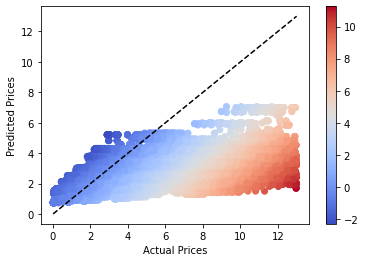

In [81]:
plt.scatter(actual_prices, predictions, c=error, cmap='coolwarm')
plt.plot(np.linspace(min(actual_prices), max(actual_prices), 100), np.linspace(
    min(actual_prices), max(actual_prices), 100), color='black', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.colorbar()
plt.show()

In [82]:
# Create a scatter plot using Plotly
fig = go.Figure(data=go.Scatter(
    x=actual_prices,
    y=predictions,
    mode='markers',
    marker=dict(
        size=8,
        color=error,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title='Error')
    )
))

fig.update_layout(
    title='Actual vs. Predicted Prices',
    xaxis=dict(title='Actual Prices'),
    yaxis=dict(title='Predicted Prices')
)

# fig.show()

# Save the Plotly figure as an HTML file
html_path = "actual_predicted_errors.html"
pio.write_html(fig, html_path)

# Log the HTML file as an artifact in MLflow
mlflow.log_artifact(html_path)

In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error


mse = mean_squared_error(actual_prices, predictions)
rmse = mean_squared_error(actual_prices, predictions, squared=False)
mae = mean_absolute_error(actual_prices, predictions)
r2 = r2_score(actual_prices, predictions)
mape = mean_absolute_percentage_error(actual_prices, predictions)

In [84]:
mlflow.log_metric("MSE", mse)
mlflow.log_metric("RMSE", rmse)
mlflow.log_metric("MAE", mae)
mlflow.log_metric("MAPE", mape)
mlflow.log_metric("R-squared", r2)

# mlflow.log_metric()

In [85]:
print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)
print('R-squared:', r2)

MSE: 9.125223213175914
RMSE: 3.020798439680462
MAE: 1.989097062757746
MAPE: 1.5163294080472758
R-squared: 0.14641441660251042


https://towardsdatascience.com/ad-demand-forecast-with-catboost-lightgbm-819e5073cd3e

https://towardsdatascience.com/understanding-feature-importance-and-how-to-implement-it-in-python-ff0287b20285

In [86]:
# End the MLflow run
mlflow.end_run()